# Copyright 2022 Cognite AS
# Part 1 - Calculating the thermal resistance

For Part 1 of the Hands-On Exercise, we will retrieve heat exchanger data from CDF using the Python SDK and use it to calculate the thermal resistance. The steps include the following:

1. Authentication and Client Creation
2. Finding data related to the system
3. Retrieve the data
4. Visualise the data
5. Calculation of the Thermal Resistance


## 1. Authentication and Client Creation

Here we'll create the Cognite client using an interactive flow. Once this client is created, this will be the main way to communicate with the Cognite Data Fusion.

Import and create a client to communicate with the Cognite Data Fusion (CDF)

In [1]:
from cognite.client import CogniteClient, ClientConfig
from cognite.client.credentials import Token
from msal import PublicClientApplication

# Contact Project Administrator to get these
TENANT_ID = "48d5043c-cf70-4c49-881c-c638f5796997"
CLIENT_ID = "1c224c70-1df2-4f05-964a-753a6731748a"
CDF_CLUSTER = "westeurope-1"
COGNITE_PROJECT = "ds-cognitefunctions"

SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]
TOKEN_URL = f"https://login.microsoftonline.com/{TENANT_ID}/oauth2/v2.0/token"
AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
PORT = 53000


def authenticate_azure():

    app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)

    # interactive login - make sure you have http://localhost:port in Redirect URI in App Registration as type "Mobile and desktop applications"
    creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT)
    return creds


creds = authenticate_azure()

cnf = ClientConfig(
    client_name="my-special-client",
    project=COGNITE_PROJECT,
    credentials=Token(creds["access_token"]),
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
)
client = CogniteClient(cnf)

This is just one of the ways to create the client, there are many other ways e.g. Device code etc
Guide for authentication and creating the client is available here https://github.com/cognitedata/python-oidc-authentication

## 2. Finding data related to the System

This can be achieved with the Hierarchy based structure in the CDF. High level System are stored as the Assets e.g. here **23-HA-9114** and **23-HA-9115** are stored as the assets. All the tags related to them are linked to the respective assets in order to access them easily.

Let's quickly get the IDs for assets we're interested in

In [2]:
asset_name = "23-HA-9114"
assets = client.assets.search(name=asset_name)
assets[:5]

,external_id,name,parent_id,parent_external_id,description,metadata,id,created_time,last_updated_time,root_id
0,WMT:23-HA-9114,23-HA-9114,6747888623258002,WMT:23-XX-9105,VRD - 1ST STAGE DISCHARGE COOLER 1,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",7690256520625010,1660131057469,1660131057469,4734486346840120
1,WMT:23-HA-9115,23-HA-9115,6747888623258002,WMT:23-XX-9105,VRD - 1ST STAGE DISCHARGE COOLER 2,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",7860450365103602,1660131057469,1660131057469,4734486346840120
2,WMT:23-VA-9114,23-VA-9114,2181587769917937,WMT:23-1ST STAGE COMP ENCLOSURE-PH,VRD - 1ST STAGE COMPRESSOR MARINE VANE SEPARATOR,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",1434328732082621,1660131093471,1660131093471,4734486346840120
3,WMT:23-GO-9114,23-GO-9114,2181587769917937,WMT:23-1ST STAGE COMP ENCLOSURE-PH,VRD - 1ST STAGE COMPPRESSOR ENCLOSURE INLET AI...,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",2623796578564691,1660131093471,1660131093471,4734486346840120
4,WMT:23-HA-9103,23-HA-9103,6747888623258002,WMT:23-XX-9105,VRD - 1ST STAGE SUCTION COOLER,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531306', ...",7508881857056099,1660131057469,1660131057469,4734486346840120


Now we can use the first two IDs to get the time series or any other data related to these two Heat Exchangers/Discharge coolers **23-HA-9114** and **23-HA-9115**

In [3]:
client.time_series.list(asset_subtree_ids=[7690256520625010, 7860450365103602])[:5]

,id,external_id,name,is_string,metadata,asset_id,is_step,description,security_categories,created_time,last_updated_time,unit
0,77942647894742,pi:160141,VAL_23_ZT_92543:Z.X.Value,False,"{'tag': 'VAL_23_ZT_92543:Z.X.Value', 'scan': '...",714801355847989,False,PH 1stStgComp Valve Pos,[],1660132610214,1660132610214,NaN
1,135468738074796,pi:160035,VAL_23_FIC_92543_06:Z.X.Value,False,"{'tag': 'VAL_23_FIC_92543_06:Z.X.Value', 'scan...",8215346898833424,False,PH 1stStgComp AntSrg Limit 1 PV,[],1660132610214,1660132610214,NaN
2,183009712684217,pi:160789,VAL_23-TIC-92604:MODE,True,"{'tag': 'VAL_23-TIC-92604:MODE', 'scan': '1', ...",1648222917026859,False,PH 1stStgDiscCool Gas Out Mode,[],1660132610214,1660132610214,NaN
3,435408197667463,pi:163523,VAL_45-PDT-92606:X.Value,False,"{'tag': 'VAL_45-PDT-92606:X.Value', 'scan': '1...",6890172724765579,False,PH 1stStgDiscCool CM,[],1660132610214,1660132610214,NaN
4,524606851609996,pi:160790,VAL_23-TIC-92604:Z.X.Value,False,"{'tag': 'VAL_23-TIC-92604:Z.X.Value', 'scan': ...",1648222917026859,False,PH 1stStgDiscCool Gas Out Measured Value,[],1660132610214,1660132610214,degC


You can also retrieve the subtree for these Assets

In [4]:
subtree = client.assets.retrieve_subtree(id=7690256520625010)
subtree[:5]

,external_id,name,parent_id,parent_external_id,description,metadata,id,created_time,last_updated_time,root_id
0,WMT:23-HA-9114,23-HA-9114,6747888623258002,WMT:23-XX-9105,VRD - 1ST STAGE DISCHARGE COOLER 1,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",7690256520625010,1660131057469,1660131057469,4734486346840120
1,WMT:23-ESDV-92551B,23-ESDV-92551B,7690256520625010,WMT:23-HA-9114,VRD - PH 1STSTGDISCHCLR GAS OUT EQ,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",38874998443314,1660131069457,1660131069457,4734486346840120
2,WMT:23-TE-92604B,23-TE-92604B,7690256520625010,WMT:23-HA-9114,VRD - PH 1STSTGDISCCOOL COOLMED IN,"{'ELC_STATUS_ID': '1212', 'SOURCE_DB': 'workma...",383251715999255,1660131069457,1660131069457,4734486346840120
3,WMT:23-ESDV-92551A,23-ESDV-92551A,7690256520625010,WMT:23-HA-9114,VRD - PH 1STSTGDISCHCLR GAS OUT,"{'ELC_STATUS_ID': '1211', 'RES_ID': '609942', ...",1245344769830348,1660131069457,1660131069457,4734486346840120
4,WMT:23-TT-92603,23-TT-92603,7690256520625010,WMT:23-HA-9114,VRD - PH 1STSTGDISCCOOL GAS OUT,"{'ELC_STATUS_ID': '1211', 'RES_ID': '654009', ...",1612035500097825,1660131069457,1660131069457,4734486346840120


There are many filtering and searching options in python sdk. refer to the documentation for more details.

## 3. Retrieve the Data

Let's Fetch the Temperatures and Flow rates for the discharge coolers.
We can look up external IDs for the sensors we're interested in and use them to filter & retrieve the data we need from CDF.

Specify the start and end date , there are also options for aggregation and granularity of data.
Note : Instead of dates, we can also specify strings for start and end dates, e.g. **start="2w-ago", end="now"**



In [5]:
column_names = [
    "T_cold_IN",
    "T_cold_OUT",
    "T_hot_IN",
    "T_hot_OUT",
    "Flow_cold",
    "Flow_hot",
]
ts_exids = [
    "pi:163657",
    "pi:163658",
    "pi:160887",
    "pi:191092",
    "pi:163374",
    "pi:160184",
]

import datetime
from datetime import timedelta

start_date = datetime.datetime(2018, 8, 1)
end_date = start_date + timedelta(days=30)

df = client.datapoints.retrieve_dataframe(
    external_id=ts_exids,
    aggregates=["average"],
    granularity="1h",
    start=start_date,
    end=end_date,
    include_aggregate_name=False,
)
df.fillna(method="ffill", inplace=True)
df.columns = column_names
df.head()

/Users/everton.colling@cognitedata.com/Documents/GitHub/learn-cognite-functions/.venv/lib/python3.10/site-packages/cognite/client/utils/_time.py:16: FutureWarning: Interpreting given naive datetime as UTC instead of local time (against Python default behaviour). This will change in the next major release (4.0.0). Please use (timezone) aware datetimes or convert it yourself to integer (number of milliseconds since epoch, leap seconds excluded).
  warnings.warn(


,T_cold_IN,T_cold_OUT,T_hot_IN,T_hot_OUT,Flow_cold,Flow_hot
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,101.142261,164362.175208
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,99.901727,163875.622135
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,100.574942,164397.399993
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,99.346718,163128.807848
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,99.440407,163634.013288


In [6]:
client.datapoints.retrieve_dataframe(
    external_id=ts_exids,
    aggregates=["average"],
    granularity="1h",
    start=start_date,
    end=end_date,
    include_aggregate_name=False,
)

/Users/everton.colling@cognitedata.com/Documents/GitHub/learn-cognite-functions/.venv/lib/python3.10/site-packages/cognite/client/utils/_time.py:16: FutureWarning: Interpreting given naive datetime as UTC instead of local time (against Python default behaviour). This will change in the next major release (4.0.0). Please use (timezone) aware datetimes or convert it yourself to integer (number of milliseconds since epoch, leap seconds excluded).
  warnings.warn(


,pi:163657,pi:163658,pi:160887,pi:191092,pi:163374,pi:160184
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,101.142261,164362.175208
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,99.901727,163875.622135
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,100.574942,164397.399993
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,99.346718,163128.807848
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,99.440407,163634.013288
...,...,...,...,...,...,...
2018-08-30 19:00:00,16.839484,108.755059,126.997908,34.957278,103.202447,164488.284327
2018-08-30 20:00:00,16.809156,109.595615,127.131659,35.251560,101.373118,164265.985099
2018-08-30 21:00:00,16.800765,109.199814,126.940651,35.102943,102.363506,164744.630989
2018-08-30 22:00:00,16.800496,109.160846,127.485644,34.970195,102.236693,163219.991616


## 4. Visualize the data

Let's quickly plot the data

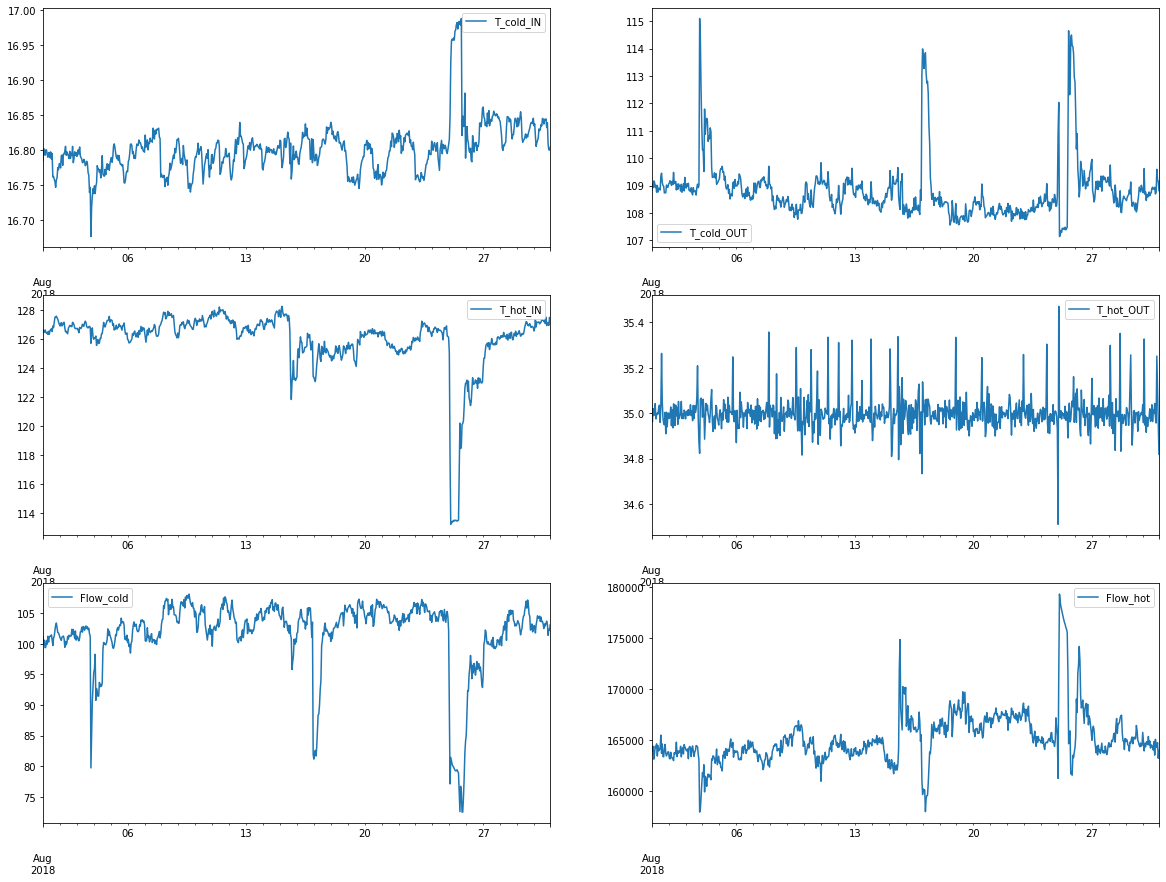

In [7]:
import matplotlib.pyplot as plt

cols = df.columns

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
for i, col in enumerate(cols):
    df.loc[:, [col]].plot(ax=axes.ravel()[i])

## 5. Heat Exchanger Calculations
First of all let's bring the mass flow rates into same unit of measurement. (kg/seconds)

In [8]:
df["Flow_cold"] = df["Flow_cold"] * 1000 / 3600.0
df["Flow_hot"] = df["Flow_hot"] / 3600.0
df.head()

,T_cold_IN,T_cold_OUT,T_hot_IN,T_hot_OUT,Flow_cold,Flow_hot
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,28.095072,45.656160
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,27.750480,45.521006
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,27.937484,45.665944
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,27.596311,45.313558
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,27.622335,45.453893


Let's create the function for **Thermal Resistance Calculation** `TR = A * F * LMTD/Q`

where A=Area, F= Correction Factor, LMTD - Log Mean Temperature Difference,
Q - Heat Transfer Rate

The Area and Correction factor are constants that are taken from the unit specification. The **Log Mean Temperature Difference** is a dynamic value that is calculated with the inlet and outlet temperatures as follows:

`LMTD = ((T_hot_IN-T_cold_OUT)-(T_hot_OUT-T_cold_IN))/(log((T_hot_IN-T_cold_OUT)/(T_hot_OUT-T_cold_IN)))`

where T_hot_IN is the inlet temperature of the hot stream, T_hot_OUT is the outlet temperature of the hot stream, T_cold_IN is the inlet temperature of the cold stream and T_cold_OUT is the outlet temperature of the cold stream.

The **Heat Transfer Q** can be calculated using the flowrate of the hot stream and the temperature difference between the inlet and the outlet.

`Q = Flow_hot * Cp_hot *(T_hot_IN-T_hot_OUT)`

where Flow_hot is the flow rate of the hot stream and Cp_hot is its heat capacity (which in this case we are treating as a thermodynamic constant. 

Let's implement these formulas in a function!

In [9]:
from math import log


def thermal_resistance(x):
    """Function to calculate Thermal Resistance"""
    # Some constants like Correction factor, Area and Cp values
    F = 0.8
    A = 1.0
    Cp_hot = 2.4
    # Calculate the cross temperature differences
    x["dT1"] = abs(x["T_hot_IN"] - x["T_cold_OUT"])
    x["dT2"] = abs(x["T_hot_OUT"] - x["T_cold_IN"])
    # Calculate the numerator and denominator for the thermal resistance calculation
    temp1 = A * F * (x["dT1"] - x["dT2"]) / log(x["dT1"] / x["dT2"])
    temp2 = x["Flow_hot"] * Cp_hot * (x["T_hot_IN"] - x["T_hot_OUT"])
    TR = temp1 / temp2
    return TR


df["TR"] = df.apply(lambda x: thermal_resistance(x), axis=1)
df.head()

,T_cold_IN,T_cold_OUT,T_hot_IN,T_hot_OUT,Flow_cold,Flow_hot,TR
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,28.095072,45.656160,0.001434
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,27.750480,45.521006,0.001424
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,27.937484,45.665944,0.001427
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,27.596311,45.313558,0.001431
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,27.622335,45.453893,0.001424


Now this calculation result is only available in this notebook, and each time  we need the value of Thermal Resitance, we'll have to fecth the data and run the above code manually. In the case, we want to presist the result of this calculation, we need to save this in CDF.

Cognite functions can be a solution for this type of calculation and saving results in CDF to be accessible later use or in other applications. 

Text(0.5, 1.0, 'Thermal Resistance')

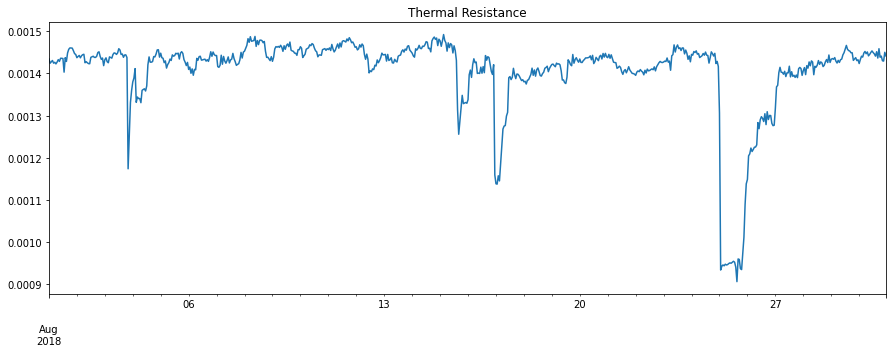

In [10]:
df["TR"].plot(figsize=(15, 5))
plt.title("Thermal Resistance")